In [1]:
"""
Simple Analysis
Student Notebook
"""

'\nSimple Analysis\nStudent Notebook\n'

In [2]:
from typing import List

import sys
import copy
import pickle
import glob

import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate

In [3]:
!{sys.executable} -m pip install git+https://github.com/thejevans/mla.git
import mla

  Cloning https://github.com/thejevans/mla.git to /tmp/pip-req-build-p0akkg7y
  Created wheel for mla-thejevans: filename=mla_thejevans-0.0.1-py3-none-any.whl size=29439 sha256=1f9ad537e66501d4c02dc1783bcda30ff9933bf83274f5c459298b3ea4297c4c
  Stored in directory: /tmp/pip-ephem-wheel-cache-or2tkz5x/wheels/3e/a7/d5/43668103cbea7473e4837ce9ebd7f6ba14f1c0ba213bc5fc0c
Successfully built mla-thejevans


In [4]:
# Change font sizes for plots
plt.rcParams.update({'font.size': 30})
plt.rcParams['axes.linewidth'] = 5
plt.rcParams['xtick.major.size'] = 15
plt.rcParams['xtick.major.width'] = 5
plt.rcParams['ytick.major.size'] = 15
plt.rcParams['ytick.major.width'] = 5

In [5]:
# File and directory locations
out_dir = './'
model_file = ''  # .pkl
#model_file = ''.join([out_dir, 'example_model.pkl'])

# If not on UMD jupyter hub, these likely need to change
dsg_root_dir = '/i3store/users/mjlarson/ps_tracks/'
sim_file = 'IC86_2012_MC.npy'  # .npy
data_files = ['IC86_2012_exp.npy',]  # .npy

grl_files = [''.join([dsg_root_dir, 'GRL/', file]) for file in data_files]  # .npy
data_files = [''.join([dsg_root_dir, file]) for file in data_files]  # .npy
sim_file = ''.join([dsg_root_dir, sim_file])  # .npy

In [6]:
def produce_and_minimize(
    pm_analysis: mla.Analysis,
    n_trials: int,
    **kwargs
) -> np.ndarray:
    """A wrapper for the built-in produce_and_minimize function that gives more detailed output."""
    print(
        f'Producing and minimizing {n_trials} trials with ',
        end='',
        flush=True,
    )

    if 'flux_norm' in kwargs:
        print(
            f'flux_norm = {kwargs["flux_norm"]:.2g}...',
            end='',
            flush=True,
        )

    else:
        print(
            f'n_signal_observed = {kwargs["n_signal_observed"]}...',
            end='',
            flush=True,
        )

    arr = mla.produce_and_minimize(
        analysis=pm_analysis,
        n_trials=n_trials,
        as_array=True,
        **kwargs,
    )

    print('done.')
    return arr

In [7]:
def print_results(to_print: np.ndarray, column_width: int = 8) -> None:
    """A pretty-print function for structured numpy arrays"""
    header = ''.join(
        [name.center(column_width) for name in to_print.dtype.names],
    )

    lines = [header, *[
        ''.join([
            f'{x : .{min(4, column_width - 2)}g}'.ljust(column_width)
            for x in result
        ])
        for result in to_print
    ]]

    print('\n'.join(lines))

In [8]:
def numpy_multifile(glob_strs: List[str]) -> np.ndarray:
    """Loads and concatonates multiple numpy files"""
    files = [file for glob_str in glob_strs for file in glob.glob(glob_str)]
    arrs = [np.load(file) for file in files]
    return np.concatenate(arrs)

In [9]:
# If model file given, load model, else load from data files
data = None
sim = None
grl = None
model = None

if model_file != '':
    print('Loading model...', end='', flush=True)

    with open(model_file, 'rb') as f:
        model = pickle.load(f)

    print('done.')

elif '' not in (*data_files, sim_file, *grl_files):
    print('Loading data...', end='', flush=True)
    data = numpy_multifile(data_files)
    print('done.\nLoading sim...', end='', flush=True)
    sim = np.load(sim_file)
    print('done.\nLoading GRL...', end='', flush=True)
    grl = numpy_multifile(grl_files)
    print('done.')

else:
    raise RuntimeError('You must either give a model or data/sim/grl')

Loading data...done.
Loading sim...done.
Loading GRL...done.


   run      event    subevent     ra       dec       azi       zen       time     trueRa   trueDec    trueE      logE     angErr      ow    
 1.103e+09 180       0         2.757     1.05      0.6804    2.619     5.593e+04 2.726     0.997     291.1     3.14      0.0521    0.06707  
 1.103e+09 318       0         1.408     0.6799    2.029     2.251     5.593e+04 1.328     0.6531    373       2.899     0.05715   0.3183   
 1.103e+09 422       0         6.236     0.7444    3.485     2.316     5.593e+04 6.232     0.7537    1099      2.643     0.01118   12.88    
 1.103e+09 531       0         1.078     1.377     2.354     2.949     5.593e+04 1.167     1.398     484.9     2.416     0.01664   0.3184   
 1.103e+09 683       0         4.665     0.01103   5.057     1.582     5.593e+04 4.656     0.01757   358.2     2.868     0.004334  0.1155   
 1.103e+09 1010      0         3.404     1.118     0.0351    2.687     5.593e+04 3.393     1.114     1668      3.046     0.01457   45.72    
 1.103e+09 11

(array([1189784., 1158318., 1130540., 1193892., 1141940., 1189372.,
        1158303., 1127505., 1179608., 1126152.]),
 array([2.18111388e-07, 6.28318726e-01, 1.25663723e+00, 1.88495574e+00,
        2.51327425e+00, 3.14159276e+00, 3.76991127e+00, 4.39822978e+00,
        5.02654828e+00, 5.65486679e+00, 6.28318530e+00]),
 <BarContainer object of 10 artists>)

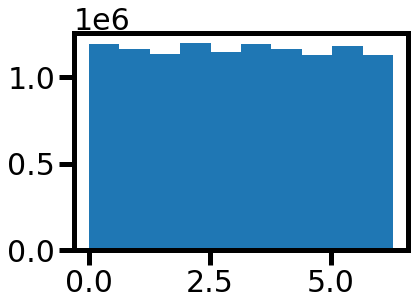

In [37]:
print_results(sim[:100], column_width=10)
plt.hist(sim['ra'])

In [10]:
# Raw numbers
injection_gamma = -2
default_fitting_gamma = -2
txs_ra = np.radians(77.3583)
txs_dec = np.radians(5.6931)
desired_start_date = 56224
length_of_desired_time_window = 158
dec_band_width = np.radians(3)

# Example source object
source = mla.Source(
    name='TXS',
    ra=txs_ra,
    dec=txs_dec,
)

# Example time profile object
uniform_profile = mla.UniformProfile(
    start=desired_start_date,
    length=length_of_desired_time_window,
)

# Example test statistic object
ts = mla.LLHTestStatistic([
    mla.SpatialTerm(),
    mla.TimeTerm(
        background_time_profile=copy.deepcopy(uniform_profile),
        signal_time_profile=copy.deepcopy(uniform_profile),
    ),
    mla.I3EnergyTerm(gamma=default_fitting_gamma),
])

# Generate model if none given
if model is None:
    print('Generating model...', end='', flush=True)

    model = mla.I3EventModel(
        source=source,
        data=data,
        sim=sim,
        grl=grl,
        gamma=injection_gamma,
        background_time_profile=copy.deepcopy(uniform_profile),
        signal_time_profile=copy.deepcopy(uniform_profile),
        sampling_width=dec_band_width,
        withinwindow=True,
    )

    model_file_loc = ''.join([out_dir, 'example_model.pkl'])

    print(
        f'done.\nSaving model to {model_file_loc}...',
        end='',
        flush=True,
    )

    with open(model_file_loc, 'wb') as f:
        pickle.dump(model, f)

    print('done.')

# Put it all together into an analysis object
analysis = mla.Analysis(
    model=model,
    test_statistic=ts,
    source=source,
)

Generating model...

/opt/conda/lib/python3.8/site-packages/mla/models.py:155: RuntimeWarning: invalid value encountered in greater
  good = np.isfinite(ratio[i]) & (ratio[i] > 0)


done.
Saving model to ./example_model.pkl...done.


   ts    gamma     ns   
 675.7  -2.142   106.8  


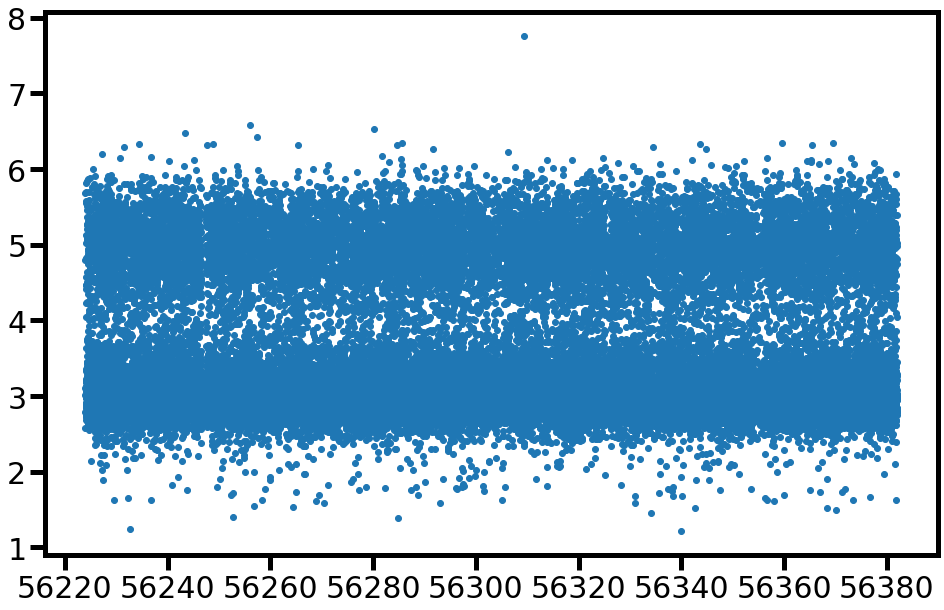

In [22]:
# Produce a trial
trial = mla.produce_trial(
    analysis=analysis,
    n_signal_observed=100,
)

# Plot the trial events
plt.figure(figsize=(16,10))
plt.scatter(trial['time'], trial['logE'])

# Generate parameter array for minimizing
test_params = mla.generate_params(
    gamma=-2,
    ns=90,
)
bounds = [(-4, -1), (0, 150)]

# Minimize the test statistic using test_params
results = mla.minimize_ts(
    analysis=analysis,
    events=trial,
    bounds=bounds,
    test_params=test_params,
    as_array=True,
)
print_results(results)

Producing and minimizing 10 trials with n_signal_observed = 100...done.
   ts    gamma     ns   
 572.8  -2.115   90     
 763.8  -1.892   93.03  
 829.4  -1.942   102.2  
 675.7  -2.08    102.9  
 635    -2.031   96.88  
 689.8  -2.065   103.8  
 628.2  -1.997   87.09  
 683.8  -2.03    100.9  
 637.5  -2.098   100.9  
 724.9  -2.1     106.3  
Producing and minimizing 100 trials with n_signal_observed = 100...done.


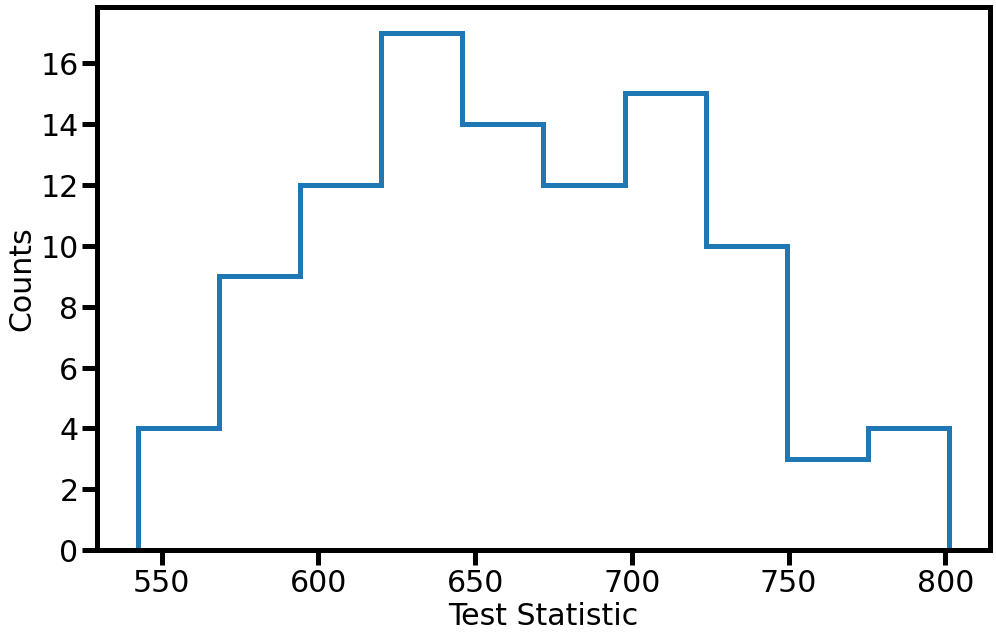

In [24]:
# Generate parameter array for minimizing
test_params = mla.generate_params(
    gamma=-2,
    ns=90,
)
bounds = [(-4, -1), (0, 150)]

# Produce 10 trials and minimize all at once
best_fit_arr = produce_and_minimize(
    pm_analysis=analysis,
    n_trials=10,
    n_signal_observed=100,
    bounds=bounds,
    test_params=test_params,
)
print_results(best_fit_arr)

# Produce and minimize 100 trials, then plot the ts distribution
best_fit_arr = produce_and_minimize(
    pm_analysis=analysis,
    n_trials=100,
    n_signal_observed=100,
    bounds=bounds,
    test_params=test_params,
)

plt.figure(figsize=(16,10))
plt.hist(best_fit_arr['ts'], histtype='step', linewidth=5)
plt.xlabel('Test Statistic')
plt.ylabel('Counts')
plt.show()

In [25]:
# Now do the same over a range of flux normalization values
flux_norms = np.empty(4)
flux_norms[0] = 0
flux_norms[1:] = np.linspace(5e-12, 3e-11, 3)

best_fits = []

for lucas in flux_norms:
    best_fits.append(produce_and_minimize(
        pm_analysis=analysis,
        n_trials=100,
        flux_norm=lucas,
        bounds=bounds,
        test_params=test_params,
    ))

# Generate parameter array for minimizing
test_params = mla.generate_params(
    gamma=-2,
    ns=90,
)
bounds = [(-4, -1), (0, 150)]

Producing and minimizing 100 trials with flux_norm = 0...done.
Producing and minimizing 100 trials with flux_norm = 5e-12...done.
Producing and minimizing 100 trials with flux_norm = 1.8e-11...done.
Producing and minimizing 100 trials with flux_norm = 3e-11...done.


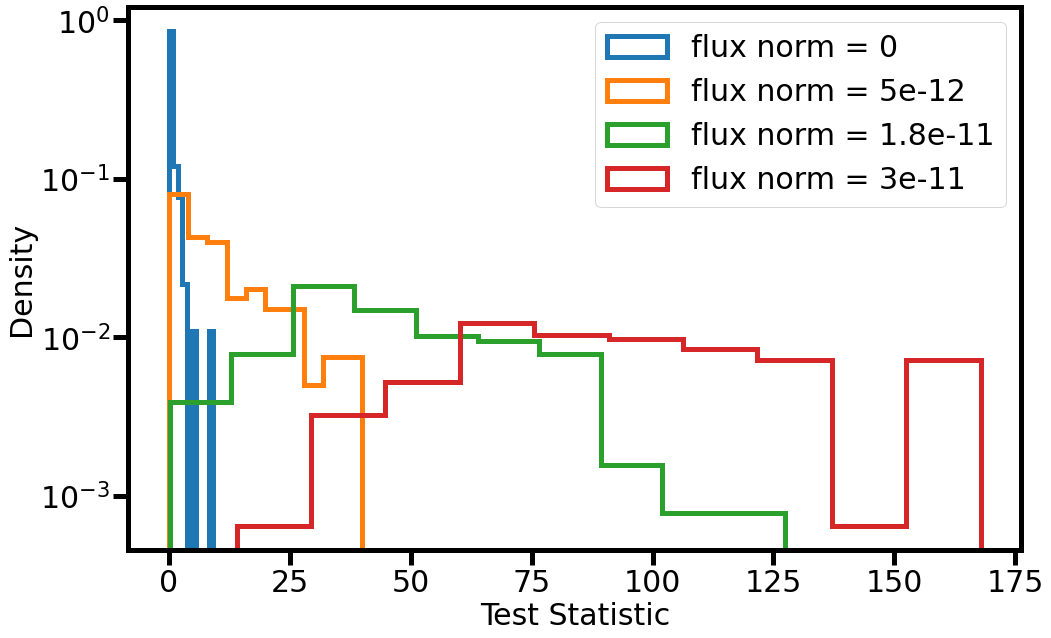

In [26]:
# Plot the TS distributions
plt.figure(figsize=(16,10))

for flux_norm, best_fit_arr in zip(flux_norms, best_fits):
    plt.hist(
        best_fit_arr['ts'],
        histtype='step',
        label=f'flux norm = {flux_norm:.2g}',
        linewidth=5,
        density=True,
    )

plt.xlabel('Test Statistic')
plt.ylabel('Density')
plt.yscale('log')
plt.legend()
plt.show()

In [27]:
# Get more TS distributions for sensitivity and discovery potential

# Generate parameter array for minimizing
test_params = mla.generate_params(
    gamma=-2,
    ns=90,
)
bounds = [(-4, -1), (0, 150)]

flux_norms = np.empty(4)
flux_norms[0] = 0
flux_norms[1:] = np.linspace(5e-12, 3e-11, 3)

best_fit_arrs = []

best_fit_arrs.append(produce_and_minimize(
    pm_analysis=analysis,
    n_trials=1000,
    flux_norm=flux_norms[0],
    bounds=bounds,
    test_params=test_params,
))

for lucas in flux_norms[1:]:
    best_fit_arrs.append(produce_and_minimize(
        pm_analysis=analysis,
        n_trials=100,
        flux_norm=lucas,
        bounds=bounds,
        test_params=test_params,
    ))

# We need more background trials to accurately get the background 3-sigma level,
# but we can still use fewer signal trials to save time.


Producing and minimizing 1000 trials with flux_norm = 0...done.
Producing and minimizing 100 trials with flux_norm = 5e-12...done.
Producing and minimizing 100 trials with flux_norm = 1.8e-11...done.
Producing and minimizing 100 trials with flux_norm = 3e-11...done.


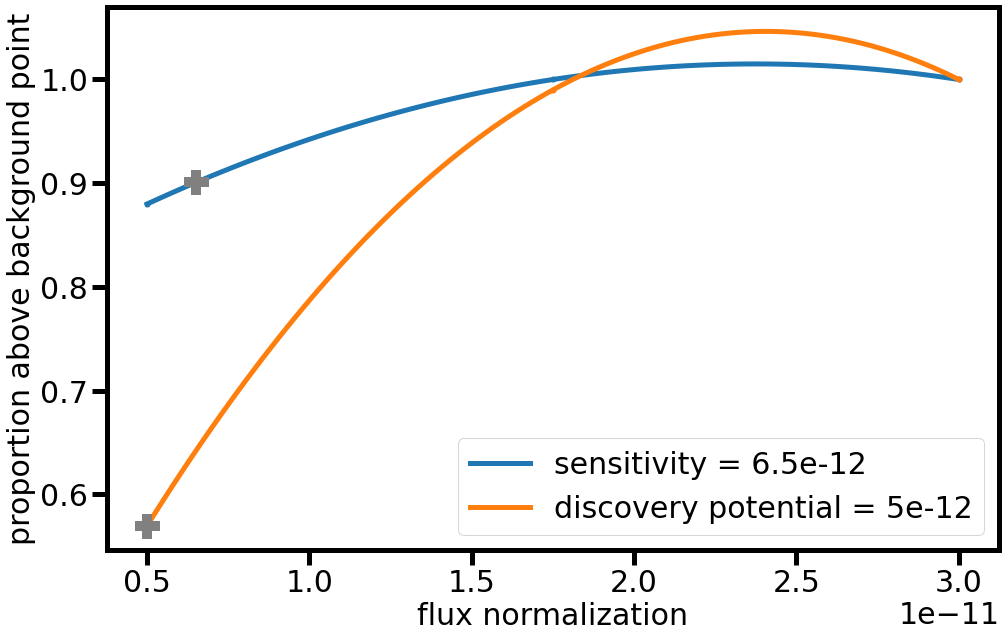

In [29]:
# Compute Sensitivity (signal 90 percentile above background 50 percentile)
bg_median = np.percentile(best_fit_arrs[0]['ts'], 50)

above_bg_median = [
    np.sum(best_fit_arr['ts'] > bg_median)/len(best_fit_arr)
    for best_fit_arr in best_fit_arrs[1:]
]
x = np.linspace(flux_norms[1], flux_norms[-1], 100)
sensitivity_spline = scipy.interpolate.UnivariateSpline(flux_norms[1:], above_bg_median, k=2)
sensitivity = x[sensitivity_spline(x) > 0.9][0]

# Compute Discovery Potential (signal 50 percentile above background 99.7 percentile or 3-sigma)
bg_3sigma = np.percentile(best_fit_arrs[0]['ts'], 99.8)
above_bg_3sigma = [
    np.sum(best_fit_arr['ts'] > bg_3sigma)/len(best_fit_arr)
    for best_fit_arr in best_fit_arrs[1:]
]
discpot_spline = scipy.interpolate.UnivariateSpline(flux_norms[1:], above_bg_3sigma, k=2)
discpot = x[discpot_spline(x) > 0.5][0]

# Plot both
plt.figure(figsize=(16,10))

plt.plot(x, sensitivity_spline(x), label=f'sensitivity = {sensitivity:.2g}', linewidth=5)
plt.plot(flux_norms[1:], above_bg_median, color='C0', marker='.', linestyle='', markersize=10)
plt.plot(sensitivity, sensitivity_spline(sensitivity), '+', color='grey', markersize=25, mew=10)

plt.plot(x, discpot_spline(x), label=f'discovery potential = {discpot:.2g}', linewidth=5)
plt.plot(flux_norms[1:], above_bg_3sigma, color='C1', marker='.', linestyle='', markersize=10)
plt.plot(discpot, discpot_spline(discpot), '+', color='grey', markersize=25, mew=10)

plt.ylabel('proportion above background point')
plt.xlabel('flux normalization')
plt.legend()
plt.show()